# EfficientNet Image Classification 2
This notebook attempts 2 more versions of the EfficientNetV2 model to optimize its performance.

## 1. Mount Google Drive (Colab Only)
This section connects to Google Drive to access the dataset.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment'

%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
assert os.path.exists(DATASET_PATH), "[!] Dataset path does not exist. Please check the path."

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment


In [2]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  %pip install lightning polars
  %pip install icecream rich tqdm

## 2. Import Libraries
Imports all required packages including PyTorch, Lightning, and data processing tools.

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datetime import datetime

# Model imports
from torchvision.models import (
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights,
    efficientnet_v2_l, EfficientNet_V2_L_Weights
)
from torchvision.transforms import v2

# Metrics imports
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix,
    Precision,
    Recall
)

# Lightning modules and callbacks
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_lightning.loggers import TensorBoardLogger

# Set random seeds for reproducibility
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


## 3. Define Dataset Classes

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset for loading and preprocessing garbage classification images."""

    def __init__(self, dataframe: pl.DataFrame, training=False, img_size=224):
        super().__init__()
        paths = dataframe['image_path'].to_numpy().squeeze()
        self.image_path = np.array([
            str(Path('preprocessed_garbage_classification_images') / Path(p).name)
            for p in paths
        ])
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training
        self.img_size = img_size

        # Enhanced augmentation for training
        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomRotation(degrees=15),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomErasing(p=0.2),
        ])

        # Base transforms for all images
        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            # Load image as grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Resize to the target size
            image = cv2.resize(image, (self.img_size, self.img_size))

            # Convert to tensor
            image = torch.from_numpy(image).float()

            # Add channel dimension if needed
            if image.dim() == 2:
                image = image.unsqueeze(0)  # Add channel dimension (C, H, W)

            # Apply augmentations if in training mode
            if self.training:
                image = self.train_transforms(image)

            # Apply basic transforms
            image = self.transforms(image)

            # Get class label
            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

In [ ]:
class GarbageClassificationData(L.LightningDataModule):
    """Data module for garbage classification dataset."""

    def __init__(self, ws_root: Path = Path("."), batch_size=32, num_workers=0, img_size=224):
        super().__init__()

        self.batch_size = batch_size
        self.img_size = img_size

        # Load datasets
        metadata_path = ws_root / 'preprocessed_garbage_classification_images' / 'metadata'
        self.train_ds = ImageDataset(
            pl.read_csv(metadata_path / 'train.csv'),
            training=True,
            img_size=self.img_size
        )
        self.val_ds = ImageDataset(
            pl.read_csv(metadata_path / 'validation.csv'),
            img_size=self.img_size
        )
        self.test_ds = ImageDataset(
            pl.read_csv(metadata_path / 'test.csv'),
            img_size=self.img_size
        )

        # Get class info
        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        # Print dataset statistics
        print(f"Number of training samples: {len(self.train_ds)}")
        print(f"Number of validation samples: {len(self.val_ds)}")
        print(f"Number of test samples: {len(self.test_ds)}")
        print(f"Number of classes: {self.n_classes}")
        print(f"Classes: {self.idx_to_garbage}")

        # DataLoader settings
        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            **self.dataloader_extras
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

## 4. Base Classifier

In [ ]:
class BaseGarbageClassifier(L.LightningModule):
    """Base class for all garbage classification models."""

    def __init__(self, n_classes, learning_rate=1e-3):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters for checkpointing
        self.save_hyperparameters()

    def forward(self, x):
        """Forward pass of the model. To be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement forward()")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Log metrics
        self.log('test_accuracy', accuracy)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        self.log('test_f1', f1_score)
        self.log('test_auroc', auroc)

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{self.__class__.__name__}.png")
        plt.show()

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
        """Configure the optimizer and learning rate scheduler."""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )

        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

## 5. Training Utilities / Functions

In [6]:
def train_and_evaluate_model(model_class, data_module, model_name, max_epochs=10, learning_rate=1e-3):
    """Train and evaluate a model without checkpointing."""

    # Create timestamp for run identification
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{model_name}_{timestamp}"

    # Create logger (for metrics, not checkpoints)
    logger = TensorBoardLogger(
        save_dir='logs',
        name=run_name,
        log_graph=False  # Disable graph logging to reduce overhead
    )

    # Create callbacks (no checkpoint callback)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min'
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Initialize trainer without checkpoint callback
    trainer = L.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        precision="16-mixed" if torch.cuda.is_available() else "32-true",
        callbacks=[early_stopping, lr_monitor],
        logger=logger,
        log_every_n_steps=10,
        enable_checkpointing=False  # Disable checkpointing
    )

    # Initialize model
    model = model_class(n_classes=data_module.n_classes, learning_rate=learning_rate)

    # Train the model
    print(f"\nTraining {model_name}...")
    trainer.fit(model=model, datamodule=data_module)

    # Test the model
    print(f"\nEvaluating {model_name}...")
    trainer.test(model=model, datamodule=data_module)

    # Save the final model (after training and testing)
    try:
        model_save_path = f"{model_name}_{timestamp}_final.pt"
        # Save only the model state dict, not the entire checkpoint
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    except Exception as e:
        print(f"Warning: Could not save model due to: {e}")
        print("Continuing without saving...")

    # Return the trained model and its metrics
    return model

## Method 3: EfficientNetV2-M with Enhanced Regularization

In [ ]:
class EfficientNetV2MAdvanced(BaseGarbageClassifier):
    """
    Enhanced EfficientNetV2-M model with:
    1. Medium-sized EfficientNetV2 backbone
    2. Advanced regularization techniques
    3. Selective layer freezing
    4. Multi-stage classifier head
    """

    def __init__(self, n_classes, learning_rate=3e-4):
        super().__init__(n_classes, learning_rate)

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Freeze early layers (more efficient and stable training)
        for i, layer in enumerate(self.model.features):
            if i < 5:  # Freeze first 5 blocks
                for param in layer.parameters():
                    param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Remove the original classifier
        self.model.classifier = nn.Identity()

        # Create a new custom classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        # Extract features
        features = self.model.features(x)
        # Apply classifier
        return self.classifier(features)

## Method 4: EfficientNetV2 Ensemble with Attention

In [ ]:
class SelfAttentionEfficientNet(BaseGarbageClassifier):
    """
    EfficientNetV2-M model with enhanced attention mechanisms:
    1. Self-attention to focus on relevant regions
    2. Channel attention to emphasize important feature maps
    3. Custom classifier with MLP head
    """

    def __init__(self, n_classes, learning_rate=5e-4):
        super().__init__(n_classes, learning_rate)

        # Load pre-trained EfficientNetV2-S model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify first convolutional layer to handle grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights properly
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Remove classifier and get feature dimension
        feature_dim = self.model.classifier[1].in_features
        self.model.classifier = nn.Identity()

        # Channel attention module (squeeze and excitation)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(feature_dim, feature_dim // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dim // 16, feature_dim, kernel_size=1),
            nn.Sigmoid()
        )

        # Spatial attention module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(feature_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )

        # Use label smoothing for regularization
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        # Extract features through the backbone
        features = self.model.features(x)

        # Apply channel attention
        ca_weights = self.channel_attention(features)
        features = features * ca_weights

        # Apply spatial attention
        sa_weights = self.spatial_attention(features)
        features = features * sa_weights

        # Apply the classifier
        return self.classifier(features)

## Method 5: Optimizing Regularization (for Model 3)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
class EfficientNetV2MOptimized(L.LightningModule):
    """
    Enhanced EfficientNetV2-M with Optimized Regularization:
    1. Learning rate scheduling
    2. Progressive unfreezing
    3. Advanced regularization techniques
    4. Mixup data augmentation
    5. Optimized training process
    """

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Unfreeze more layers as training progresses
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Method 6: Change to a larger backbone (EfficientNetV2-L)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
class EfficientNetV2L(L.LightningModule):
    """
    Changed EfficientNetV2-M to EfficientNetV2-L:
    """

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Unfreeze more layers as training progresses
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Method 7: Change optimizer to RAdam

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
class EfficientNetV2M_RAdam(L.LightningModule):
    """
    Change back to EfficientNetV2-M & change optimizer to RAdam:
    """

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Unfreeze more layers as training progresses
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.RAdam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Method 8: Try DropBlock instead of standard Dropout & Optimizer as RAdam

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
class DropBlock2D(nn.Module):
    """
    DropBlock: A regularization method for convolutional networks.
    Instead of dropping random pixels, it drops contiguous regions of the feature map.

    Args:
        drop_prob (float): Probability of activating DropBlock
        block_size (int): Size of the block to drop
    """
    def __init__(self, drop_prob=0.1, block_size=7):
        super(DropBlock2D, self).__init__()
        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # If not in training mode or drop_prob is 0, return input
        if not self.training or self.drop_prob == 0:
            return x

        # Get dimensions
        _, _, height, width = x.shape

        # Calculate gamma (sampling rate)
        gamma = self.drop_prob / (self.block_size ** 2)

        # Sample mask
        mask = torch.rand(x.shape[0], 1, height, width, device=x.device) < gamma

        # Calculate block mask by average pooling the random mask
        block_mask = F.max_pool2d(
            input=mask.float(),
            kernel_size=(self.block_size, self.block_size),
            stride=(1, 1),
            padding=self.block_size // 2
        )

        # Invert the block mask and reshape
        block_mask = 1 - block_mask

        # Normalize the features
        norm_scale = block_mask.numel() / (block_mask.sum() + 1e-7)

        # Apply mask
        return x * block_mask * norm_scale

class EfficientNetV2M_DropBlock(L.LightningModule):
    """
    Enhanced EfficientNetV2-M with DropBlock regularization:
    - Replaces standard Dropout with DropBlock in the classifier
    - Adds DropBlock to the feature extractor at specific stages
    """

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Apply DropBlock to intermediate feature blocks
        # Insert DropBlock at specific layers in the feature extractor
        # These are selected to be after major blocks in the EfficientNetV2 architecture
        self._insert_dropblock_layers()

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head using DropBlock instead of Dropout
        self.model.classifier = nn.Sequential(
            # For linear layers we still use standard Dropout
            nn.Dropout(0.4),
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def _insert_dropblock_layers(self):
        """
        Insert DropBlock layers into the feature extractor.
        We target specific layers in the network, placing DropBlock modules
        strategically throughout the architecture.
        """
        # Configuration for where to insert DropBlock and with what parameters
        # Format: (block_index, drop_prob, block_size)
        # Block sizes are chosen based on feature map size (smaller for deeper layers)
        insertion_points = [
            (2, 0.05, 7),   # Early layer - lower drop prob, larger block
            (4, 0.07, 5),   # Mid layer
            (6, 0.1, 3)     # Deeper layer - higher drop prob, smaller block
        ]

        # For each insertion point, add DropBlock after the specified block
        for block_idx, drop_prob, block_size in insertion_points:
            if block_idx < len(self.model.features):
                # The original block
                original_block = self.model.features[block_idx]

                # Create a new sequential block with the original + DropBlock
                new_block = nn.Sequential(
                    original_block,
                    DropBlock2D(drop_prob=drop_prob, block_size=block_size)
                )

                # Replace the original block
                self.model.features[block_idx] = new_block

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Unfreeze more layers as training progresses
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Method 9: Try DropBlock instead of standard Dropout & Optimizer as RAdam

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
class DropBlock2D(nn.Module):
    """
    DropBlock: A regularization method for convolutional networks.
    Instead of dropping random pixels, it drops contiguous regions of the feature map.

    Args:
        drop_prob (float): Probability of activating DropBlock
        block_size (int): Size of the block to drop
    """
    def __init__(self, drop_prob=0.1, block_size=7):
        super(DropBlock2D, self).__init__()
        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # If not in training mode or drop_prob is 0, return input
        if not self.training or self.drop_prob == 0:
            return x

        # Get dimensions
        _, _, height, width = x.shape

        # Calculate gamma (sampling rate)
        gamma = self.drop_prob / (self.block_size ** 2)

        # Sample mask
        mask = torch.rand(x.shape[0], 1, height, width, device=x.device) < gamma

        # Calculate block mask by average pooling the random mask
        block_mask = F.max_pool2d(
            input=mask.float(),
            kernel_size=(self.block_size, self.block_size),
            stride=(1, 1),
            padding=self.block_size // 2
        )

        # Invert the block mask and reshape
        block_mask = 1 - block_mask

        # Normalize the features
        norm_scale = block_mask.numel() / (block_mask.sum() + 1e-7)

        # Apply mask
        return x * block_mask * norm_scale

class EfficientNetV2M_DropBlock_RAdam(L.LightningModule):
    """
    Enhanced EfficientNetV2-M with DropBlock regularization:
    - Replaces standard Dropout with DropBlock in the classifier
    - Adds DropBlock to the feature extractor at specific stages
    """

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Modify the first convolutional layer to accept grayscale input
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )

        # Initialize weights with the average of RGB channels
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.model.features[0][0] = new_conv

        # Apply DropBlock to intermediate feature blocks
        # Insert DropBlock at specific layers in the feature extractor
        # These are selected to be after major blocks in the EfficientNetV2 architecture
        self._insert_dropblock_layers()

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head using DropBlock instead of Dropout
        self.model.classifier = nn.Sequential(
            # For linear layers we still use standard Dropout
            nn.Dropout(0.4),
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def _insert_dropblock_layers(self):
        """
        Insert DropBlock layers into the feature extractor.
        We target specific layers in the network, placing DropBlock modules
        strategically throughout the architecture.
        """
        # Configuration for where to insert DropBlock and with what parameters
        # Format: (block_index, drop_prob, block_size)
        # Block sizes are chosen based on feature map size (smaller for deeper layers)
        insertion_points = [
            (2, 0.05, 7),   # Early layer - lower drop prob, larger block
            (4, 0.07, 5),   # Mid layer
            (6, 0.1, 3)     # Deeper layer - higher drop prob, smaller block
        ]

        # For each insertion point, add DropBlock after the specified block
        for block_idx, drop_prob, block_size in insertion_points:
            if block_idx < len(self.model.features):
                # The original block
                original_block = self.model.features[block_idx]

                # Create a new sequential block with the original + DropBlock
                new_block = nn.Sequential(
                    original_block,
                    DropBlock2D(drop_prob=drop_prob, block_size=block_size)
                )

                # Replace the original block
                self.model.features[block_idx] = new_block

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Unfreeze more layers as training progresses
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.RAdam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Training + Evaluation of methods

In [ ]:
# Prepare data module (shared between models)
data_module = GarbageClassificationData(
    batch_size=16,
    num_workers=4,
    img_size=224
)

Number of training samples: 5080
Number of validation samples: 1091
Number of test samples: 1090
Number of classes: 8
Classes: {0: 'Glass', 1: 'Hazardous Waste', 2: 'Metal', 3: 'Organic Waste', 4: 'Paper & Cardboard', 5: 'Plastic', 6: 'Textiles', 7: 'Trash'}


### Method 3 Training

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of training samples: 5080
Number of validation samples: 1091
Number of test samples: 1090
Number of classes: 8
Classes: {0: 'Glass', 1: 'Hazardous Waste', 2: 'Metal', 3: 'Organic Waste', 4: 'Paper & Cardboard', 5: 'Plastic', 6: 'Textiles', 7: 'Trash'}

=== Training Model 1: EfficientNetV2-M Advanced ===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                  | Type                      | Params | Mode 
-----------------------------------------------------------------------------
0  | criterion             | CrossEntropyLoss          | 0      | train
1  | train_acc             | MulticlassAccuracy        | 0      | train
2  | val_acc               | MulticlassAccuracy        | 0      | train
3  | test_accuracy         | MulticlassAccuracy        | 0      | train
4  | test_precision        | MulticlassPrecision       | 0      | train
5  | test_recall           | MulticlassRecall          | 0      | train
6  | test_f1               | MulticlassF1Score         | 0      | train
7  | test_auroc            | MulticlassAUROC           | 0      | train
8  | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
9  | model                 | EfficientNet              | 52.9 M 


Training EfficientNetV2M_Advanced...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2M_Advanced...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8358
Precision: 0.8322
Recall: 0.8315
F1 Score: 0.8314
AUROC: 0.9712


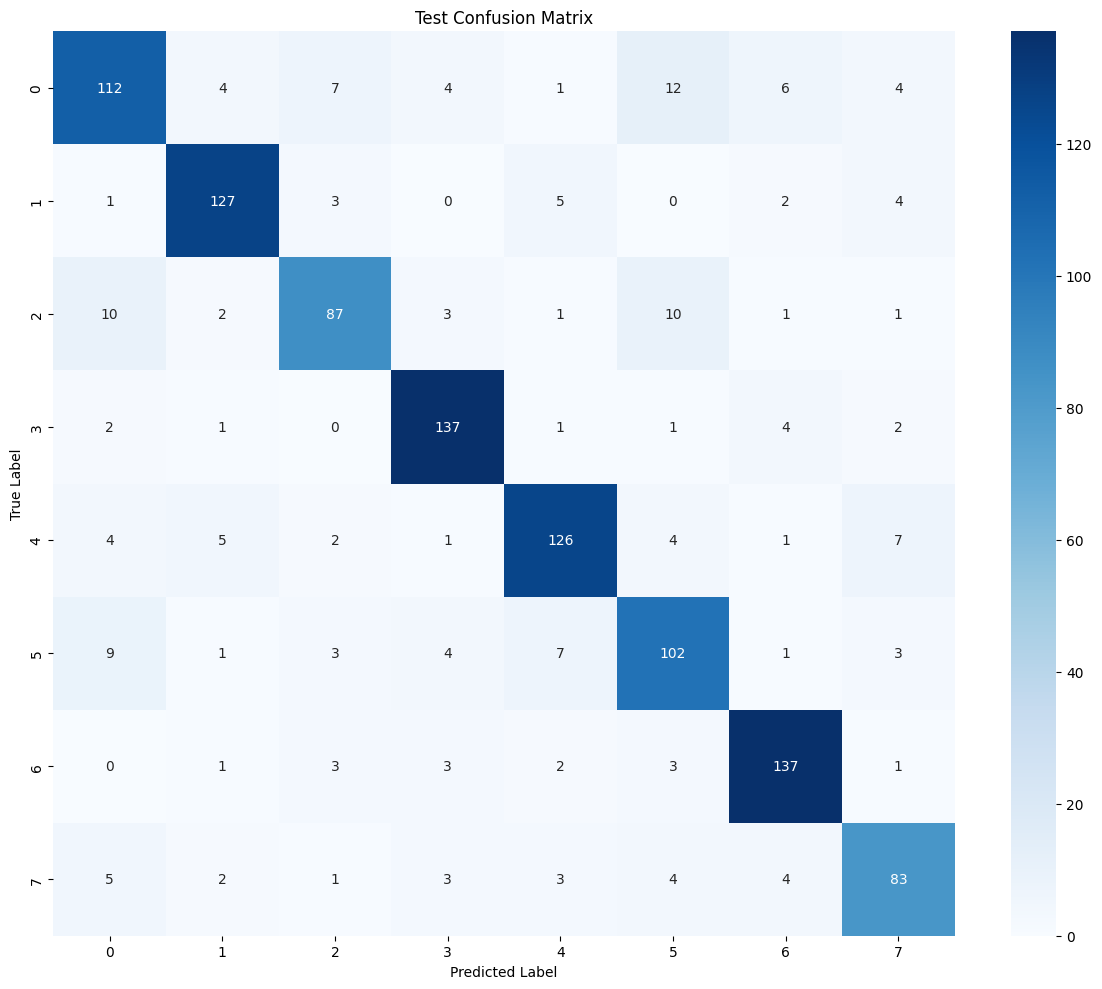

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8357798457145691     │
│        test_auroc         │    0.9712444543838501     │
│          test_f1          │    0.8314404487609863     │
│         test_loss         │    0.8986123204231262     │
│      test_precision       │     0.832206130027771     │
│        test_recall        │    0.8314568996429443     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2M_Advanced_20250405_165553_final.pt


In [ ]:
# Model 1: EfficientNetV2-M with Enhanced Regularization
print("\n=== Training Model 1: EfficientNetV2-M Advanced ===")
model1 = train_and_evaluate_model(
    model_class=EfficientNetV2MAdvanced,
    data_module=data_module,
    model_name="EfficientNetV2M_Advanced",
    max_epochs=15,
    learning_rate=3e-4
)

In [ ]:
torch.save(model1.state_dict(), "saved_efficientnet/efficientnetv2-method3_weights.pth")
torch.save(model1, "saved_efficientnet/efficientnetv2-method3.pth")

### Method 4 Training

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 2: Self-Attention Enhanced EfficientNet ===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                  | Type                      | Params | Mode 
-----------------------------------------------------------------------------
0  | criterion             | CrossEntropyLoss          | 0      | train
1  | train_acc             | MulticlassAccuracy        | 0      | train
2  | val_acc               | MulticlassAccuracy        | 0      | train
3  | test_accuracy         | MulticlassAccuracy        | 0      | train
4  | test_precision        | MulticlassPrecision       | 0      | train
5  | test_recall           | MulticlassRecall          | 0      | train
6  | test_f1               | MulticlassF1Score         | 0      | train
7  | test_auroc            | MulticlassAUROC           | 0      | train
8  | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
9  | model                 | EfficientNet              | 52.9 M 


Training SelfAttention_EfficientNet...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating SelfAttention_EfficientNet...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8183
Precision: 0.8172
Recall: 0.8141
F1 Score: 0.8141
AUROC: 0.9727


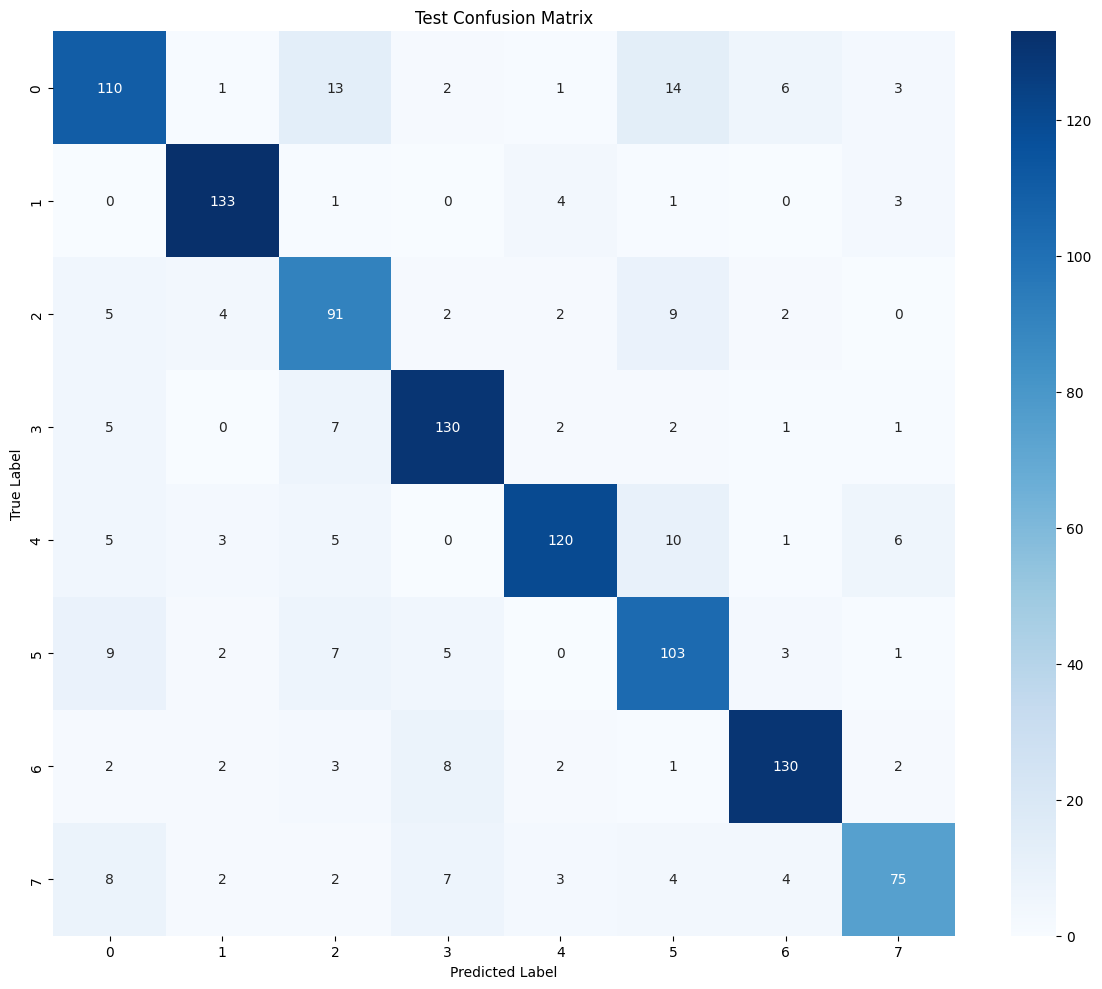

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8183486461639404     │
│        test_auroc         │     0.97273188829422      │
│          test_f1          │    0.8141456842422485     │
│         test_loss         │     0.901638388633728     │
│      test_precision       │    0.8171953558921814     │
│        test_recall        │    0.8141120076179504     │
└───────────────────────────┴───────────────────────────┘

Model saved to SelfAttention_EfficientNet_20250405_172412_final.pt


In [ ]:
# Model 2: Self-Attention Enhanced EfficientNet
print("\n=== Training Model 2: Self-Attention Enhanced EfficientNet ===")
model2 = train_and_evaluate_model(
  model_name="SelfAttention_EfficientNet",
  model_class=SelfAttentionEfficientNet,
  data_module=data_module,
  max_epochs=15,
  learning_rate=5e-4
)

In [ ]:
torch.save(model2.state_dict(), "saved_efficientnet/efficientnetv2-method4_weights.pth")
torch.save(model2, "saved_efficientnet/efficientnetv2-method4.pth")

### Method 5 Training

In [ ]:
# Model 5
print("\n=== Training Model 5: Enhanced EfficientNetV2-M with Optimized Regularization ===")
model5 = train_and_evaluate_model(
  model_name="EfficientNetV2MOptimized",
  model_class=EfficientNetV2MOptimized,
  data_module=data_module,
  max_epochs=20,
  learning_rate=3e-4
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 3: Enhanced EfficientNetV2-M with Optimized Regularization ===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.



Training EfficientNetV2MOptimized...


INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 54.7 M | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | train_acc             | MulticlassAccuracy        | 0      | train
3 | val_acc               | MulticlassAccuracy        | 0      | train
4 | test_accuracy         | MulticlassAccuracy        | 0      | train
5 | test_precision        | MulticlassPrecision       | 0      | train
6 | test_recall           | MulticlassRecall          | 0      | train
7 | test_f1               | MulticlassF1Score         | 0      | train
8 | test_auroc            | MulticlassAUROC           | 0      | train
9 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
1.8 M     Trainable params
52.9 M    Non-trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 6 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 3 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing all layers


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2MOptimized...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8514
Precision: 0.8531
Recall: 0.8467
F1 Score: 0.8489
AUROC: 0.9760


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8218135237693787     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2MOptimized_20250405_191451_final.pt


In [ ]:
torch.save(model5.state_dict(), "saved_efficientnet/efficientnetv2-method5_weights.pth")
torch.save(model5, "saved_efficientnet/efficientnetv2-method5.pth")

### Method 6 Training

In [ ]:
# Model 6
print("\n=== Training Model 6: Change to a larger backbone (EfficientNetV2-L) ===")
model6 = train_and_evaluate_model(
  model_name="EfficientNetV2L",
  model_class=EfficientNetV2L,
  data_module=data_module,
  max_epochs=20,
  learning_rate=3e-4
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 3: Enhanced EfficientNetV2-M with Optimized Regularization ===


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 163MB/s]



Training EfficientNetV2L...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 119 M  | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 6 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 3 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing all layers


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2L...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8495
Precision: 0.8466
Recall: 0.8459
F1 Score: 0.8457
AUROC: 0.9774


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8336644172668457     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2L_20250410_015546_final.pt


In [ ]:
torch.save(model6.state_dict(), "saved_efficientnet/efficientnetv2-method6_weights.pth")
torch.save(model6, "saved_efficientnet/efficientnetv2-method6.pth")

### Method 7 Training

In [ ]:
# Model 7
print("\n=== Training Model 7: Change optimizer to RAdam ===")
model7 = train_and_evaluate_model(
  model_name="EfficientNetV2M_RAdam",
  model_class=EfficientNetV2M_RAdam,
  data_module=data_module,
  max_epochs=20,
  learning_rate=3e-4
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 7: Change optimizer to RAdam ===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training EfficientNetV2M_RAdam...


INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 54.7 M | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | train_acc             | MulticlassAccuracy        | 0      | train
3 | val_acc               | MulticlassAccuracy        | 0      | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 6 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 3 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing all layers


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2M_RAdam...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8532
Precision: 0.8539
Recall: 0.8483
F1 Score: 0.8502
AUROC: 0.9750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8285186886787415     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2M_RAdam_20250410_075157_final.pt


In [ ]:
torch.save(model7.state_dict(), "saved_efficientnet/efficientnetv2-method7_weights.pth")
torch.save(model7, "saved_efficientnet/efficientnetv2-method7.pth")

### Method 8 Training

In [ ]:
# Model 8
print("\n=== Training Model 8: Try DropBlock instead of standard Dropout ===")
model8 = train_and_evaluate_model(
  model_name="EfficientNetV2M_DropBlock",
  model_class=EfficientNetV2M_DropBlock,
  data_module=data_module,
  max_epochs=20,
  learning_rate=3e-4
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 8: Try DropBlock instead of standard Dropout ===


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.



Training EfficientNetV2M_DropBlock...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 54.7 M | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | train_acc             | MulticlassAccuracy        | 0      | train
3 | val_acc               | MulticlassAccuracy        | 0      | train
4 | test_accuracy         | MulticlassAccuracy        | 0      | train
5 | test_precision        | Multicl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 6 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 3 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing all layers


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2M_DropBlock...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8422
Precision: 0.8447
Recall: 0.8384
F1 Score: 0.8396
AUROC: 0.9744


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8538373708724976     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2M_DropBlock_20250410_083803_final.pt


In [ ]:
torch.save(model8.state_dict(), "saved_efficientnet/efficientnetv2-method8_weights.pth")
torch.save(model8, "saved_efficientnet/efficientnetv2-method8.pth")

### Method 9 Training

In [7]:
# Model 9
print("\n=== Training Model 9: Try DropBlock instead of standard Dropout & Optimizer as RAdam ===")
model9 = train_and_evaluate_model(
  model_name="EfficientNetV2M_DropBlock_RAdam",
  model_class=EfficientNetV2M_DropBlock_RAdam,
  data_module=data_module,
  max_epochs=20,
  learning_rate=3e-4
)


=== Training Model 9: Try DropBlock instead of standard Dropout & Optimizer as RAdam ===


NameError: name 'EfficientNetV2M_DropBlock_RAdam' is not defined

In [8]:
torch.save(model9.state_dict(), "saved_efficientnet/efficientnetv2-method9_weights.pth")
torch.save(model9, "saved_efficientnet/efficientnetv2-method9.pth")

NameError: name 'model9' is not defined

### Method 10 Training (Increased epochs to 30)

In [ ]:
# Model 10
print("\n=== Training Model 10: Increased epochs to 30 ===")
model10 = train_and_evaluate_model(
  model_name="EfficientNetV2M_DropBlock_RAdam",
  model_class=EfficientNetV2M_DropBlock_RAdam,
  data_module=data_module,
  max_epochs=30,
  learning_rate=3e-4
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Model 10: Increased epochs to 30 ===


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 129MB/s]



Training EfficientNetV2M_DropBlock_RAdam...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | EfficientNet              | 54.7 M | train
1 | criterion             | CrossEntropyLoss          | 0      | train
2 | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 6 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing layers from 3 to 8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing all layers


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating EfficientNetV2M_DropBlock_RAdam...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.8587
Precision: 0.8601
Recall: 0.8546
F1 Score: 0.8566
AUROC: 0.9772


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8266053795814514     │
└───────────────────────────┴───────────────────────────┘

Model saved to EfficientNetV2M_DropBlock_RAdam_20250413_122001_final.pt


In [ ]:
torch.save(model10.state_dict(), "saved_efficientnet/efficientnetv2-method10_weights.pth")
torch.save(model10, "saved_efficientnet/efficientnetv2-method10.pth")

Knowledge Distillation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=4.0):
        super().__init__()
        self.alpha = alpha  # Weight for distillation loss
        self.T = temperature  # Temperature for softening probability distributions
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, student_logits, teacher_logits, labels):
        # Regular cross-entropy loss
        ce_loss = self.ce_loss(student_logits, labels)

        # Knowledge distillation loss
        distillation_loss = F.kl_div(
            F.log_softmax(student_logits / self.T, dim=1),
            F.softmax(teacher_logits / self.T, dim=1),
            reduction='batchmean'
        ) * (self.T ** 2)

        # Combine losses
        return self.alpha * ce_loss + (1 - self.alpha) * distillation_loss

class DistilledEfficientNet(L.LightningModule):
    def __init__(self, student_model, teacher_model, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.student = student_model
        self.teacher = teacher_model

        # Freeze teacher model
        for param in self.teacher.parameters():
            param.requires_grad = False
        self.teacher.eval()

        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Distillation loss
        self.distill_loss = DistillationLoss(alpha=0.3, temperature=4.0)

        # Metrics (same as before)
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)

    def forward(self, x):
        return self.student(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Get student predictions
        student_logits = self.student(x)

        # Get teacher predictions (no grad)
        with torch.no_grad():
            teacher_logits = self.teacher(x)

        # Calculate distillation loss
        loss = self.distill_loss(student_logits, teacher_logits, y)

        # Metrics
        preds = torch.argmax(student_logits, dim=1)
        acc = self.train_acc(preds, y)

        # Log
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        # Use RAdam optimizer as in your successful model
        from torch.optim import RAdam

        optimizer = RAdam(
            self.student.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # One cycle learning rate scheduler
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1,
            div_factor=25,
            final_div_factor=1000,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

# Example usage:
def train_distilled_model():
    # Load your best model (model10)
    teacher_model = torch.load("saved_efficientnet/efficientnetv2-method10.pth")
    teacher_model.eval()

    # Create a new student model with same architecture
    student_model = EfficientNetV2M_DropBlock_RAdam(n_classes=YOUR_NUM_CLASSES)

    # Create distilled model
    distilled_model = DistilledEfficientNet(
        student_model=student_model,
        teacher_model=teacher_model,
        n_classes=YOUR_NUM_CLASSES,
        learning_rate=3e-4,
        weight_decay=1e-4
    )

    # Train with distillation
    trainer = L.Trainer(
        max_epochs=30,
        callbacks=[
            L.callbacks.ModelCheckpoint(
                monitor="val_acc",
                mode="max",
                save_top_k=1
            ),
            L.callbacks.EarlyStopping(
                monitor="val_acc",
                patience=5,
                mode="max"
            )
        ]
    )

    trainer.fit(distilled_model, data_module)

    # Evaluate
    results = trainer.test(distilled_model, data_module)
    return distilled_model, results

## Comparison of Results